In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from quasinet.qsampling import qsample
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(
    df,
    df_pos=None,
    df_neg=None,
    diss_file=None,
):
    if df_pos is not None and df_neg is not None:
        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )
        Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
        Tr_pos = _get_qnet(
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        Tr_neg = _get_qnet(
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
    else:
        Tr = truthnet()
        length = sum(df.isna().sum() < len(df))
        df.to_csv("tmpfile.csv", index=False)
        features, samples = Tr.load_data(datapath="tmpfile.csv")
        Tr.fit(modelpath="tmp_Qnet.joblib")
        if diss_file is not None:
            Tr.dissonance = pd.read_csv(diss_file)
        else:
            Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
        coresamples = Tr.getCoresamples(alpha=0.01, steps=length)
        df_neg = df.loc[coresamples.index.values]
        df_pos = df.loc[~df.index.isin(coresamples.index.values)]

        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )

        Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
        Tr_neg = _get_qnet(
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        Tr_pos = _get_qnet(
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )

    return {
        "all": Tr,
        "pos": Tr_pos,
        "neg": Tr_neg,
        "data": df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""),
    }


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _sample_with_dissonance(
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    if order is None:
        order = range(length)

    if data_samples is not None:
        data_samples_df = pd.DataFrame(data_samples)
        data_sample_values = pd.Series(
            {
                col: [x for x in data_samples_df[col].unique() if x != ""]
                for col in data_samples_df
            }
        )

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        if sample_model is not None:
            prob_dict = sample_model.predict_distribution(sample, i)
            sample[i] = sample_from_dict(prob_dict)
        else:
            sample[i] = random.choice(data_sample_values[i])
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples,
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    n_runif_samples=None,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    if order == "random":
        order = list(range(length))
        random.shuffle(order)

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    if n_runif_samples is not None:
        samples["runif"], dissonances["runif"] = _nsamples_with_dissonance(
            n_runif_samples,
            None,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    iter,
    name,
    df,
    n_qsamples,
    n_m2_samples,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    diss_fcn=_diss_linear,
    order=None,
    n_runif_samples=None,
    invert_pos=False,
):
    for i in tqdm(iter):
        tn = _get_tnets(
            df=df,
            df_pos=df_pos,
            df_neg=df_neg,
            diss_file=diss_file,
        )

        data_samples = tn["data"]
        full_model = tn["all"]
        if invert_pos is True:
            pos_model = tn["neg"]
            neg_model = tn["pos"]
        else:
            pos_model = tn["pos"]
            neg_model = tn["neg"]

        length = len(full_model.feature_names)

        diss_models = [full_model, neg_model, pos_model]

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            n_runif_samples,
            diss_fcn,
            order,
            data_samples=data_samples,
        )

        pd.to_pickle(s, f"{name}_{order}_order_samples_{i}.pkl")
        pd.to_pickle(d, f"{name}_{order}_order_disson_{i}.pkl")

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    name="disson_ptsd/core/disson_ptsd_core",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

In [4]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_samples*.pkl")
]

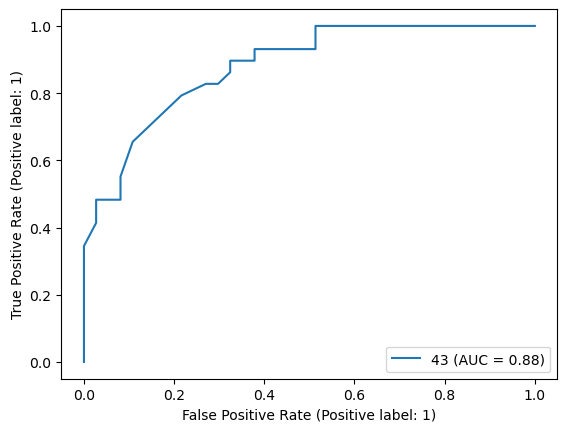

In [5]:
groups = ["qsampled", "runif"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }
                # param = {
                #    "objective": "binary",
                #    "metric": "auc",
                #    "verbosity": -1,
                #    "boosting_type": "gbdt",
                #    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                #    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                #    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                #    "feature_fraction": trial.suggest_float(
                #        "feature_fraction", 0.4, 1.0
                #    ),
                #    "bagging_fraction": trial.suggest_float(
                #        "bagging_fraction", 0.4, 1.0
                #    ),
                #    "bagging_freq": trial.suggest_int("bagging_freq", 1, #7),
                #    "min_child_samples": trial.suggest_int#("min_child_samples", 5, 100),
                # }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

In [11]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.624045,0.009282,0.588070,0.660021
1,6,0.826443,0.003303,0.804983,0.847904
2,11,0.881777,0.001575,0.866960,0.896594
3,16,0.907561,0.001534,0.892935,0.922188
4,21,0.932717,0.000983,0.921010,0.944424
5,26,0.950140,0.000624,0.940809,0.959470
6,31,0.961087,0.000500,0.952739,0.969435
7,36,0.970893,0.000404,0.963389,0.978398
8,41,0.970979,0.000674,0.961282,0.980676
9,46,0.977850,0.000136,0.973492,0.982208


In [13]:
results_path = "data/classification/ptsd/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)